In [2]:
pip install torch

   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/203.1 MB 2.6 MB/s eta 0:01:20
   ---------------------------------------- 0.2/203.1 MB 1.6 MB/s eta 0:02:05
   ---------------------------------------- 0.3/203.1 MB 2.5 MB/s eta 0:01:20
   ---------------------------------------- 0.4/203.1 MB 2.5 MB/s eta 0:01:20
   ---------------------------------------- 0.5/203.1 MB 2.0 MB/s eta 0:01:41
   ---------------------------------------- 0.6/203.1 MB 2.0 MB/s eta 0:01:44
   ---------------------------------------- 0.7/203.1 MB 2.1 MB/s eta 0:01:36
   ---------------------------------------- 0.7/203.1 MB 1.9 MB/s eta 0:01:49
   ---------------------------------------- 0.8/203.1 MB 2.0 MB/s eta 0:01:42
   ---------------------------------------- 0.9/203.1 MB 2.0 MB/s eta 0:01:41
   ---------------------------------------- 0.9/203.1 MB 1.7 MB/s eta 0:02:02
   ---------------------------------------- 0.9/203.1 MB 1.6 MB/s eta 0


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\ADITYA\AppData\Local\Temp\ipykernel_10840\1208840413.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = self.transform(image)


Test accuracy: 0.9584


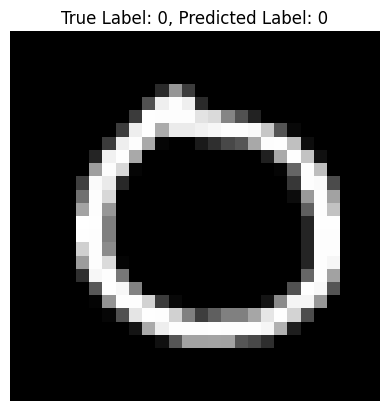

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Load the CSV file
data = pd.read_csv(r"E:\Deep Learning Datasets-20241106T032755Z-001\Deep Learning Datasets\3 MNIST\mnist_784_csv.csv")  # Replace with your actual file path

# Separate features (pixel values) and labels (class)
X = data.drop(columns=['class']).values  # Features: Pixel values
y = data['class'].values                # Labels: Class values

# Normalize the images by scaling pixel values to [0, 1]
X = X / 255.0

# Reshape the images to 28x28
X = X.reshape(-1, 28, 28)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Ensure the image is in float32 format for compatibility with model
        image = torch.tensor(image, dtype=torch.float32)  # Convert to float32
        if self.transform:
            image = self.transform(image)
        return image, label

# Create DataLoader for training and testing
train_dataset = CustomDataset(X_train, y_train, transform=torch.tensor)
test_dataset = CustomDataset(X_test, y_test, transform=torch.tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define the model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer
        self.fc2 = nn.Linear(128, 10)        # Output layer

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))          # ReLU activation
        x = torch.softmax(self.fc2(x), dim=1) # Softmax activation
        return x

# Create the model, define the loss function and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
for epoch in range(5):  # Train for 5 epochs
    for images, labels in train_loader:
        optimizer.zero_grad()        # Zero the gradients
        outputs = model(images)      # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()              # Backward pass
        optimizer.step()             # Update the weights

# Evaluate the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test accuracy: {correct / total:.4f}')

# Make a prediction on a random test image
random_index = np.random.randint(0, len(test_dataset))
test_image, test_label = test_dataset[random_index]

# Predict the class
model.eval()  # Set to evaluation mode
with torch.no_grad():
    output = model(test_image.unsqueeze(0).float())  # Add batch dimension and ensure correct dtype
    predicted_label = torch.argmax(output).item()

# Visualize the test image and prediction
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title(f'True Label: {test_label}, Predicted Label: {predicted_label}')
plt.axis('off')
plt.show()